<a href="https://colab.research.google.com/github/Yan4S/DataAnalysis/blob/main/Titanic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/Yan4S/DataAnalysis.git

Cloning into 'DataAnalysis'...
remote: Enumerating objects: 89, done.
remote: Counting objects: 100% (89/89), done.
remote: Compressing objects: 100% (82/82), done.
remote: Total 89 (delta 37), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (89/89), 64.31 KiB | 2.01 MiB/s, done.
Resolving deltas: 100% (37/37), done.


In [2]:
!ls DataAnalysis/Kaggle

README.md  Titanic_gender_submission.csv  Titanic_test.csv  Titanic_train.csv


In [4]:
folderPath = 'DataAnalysis/Kaggle/'

## Plotter Code

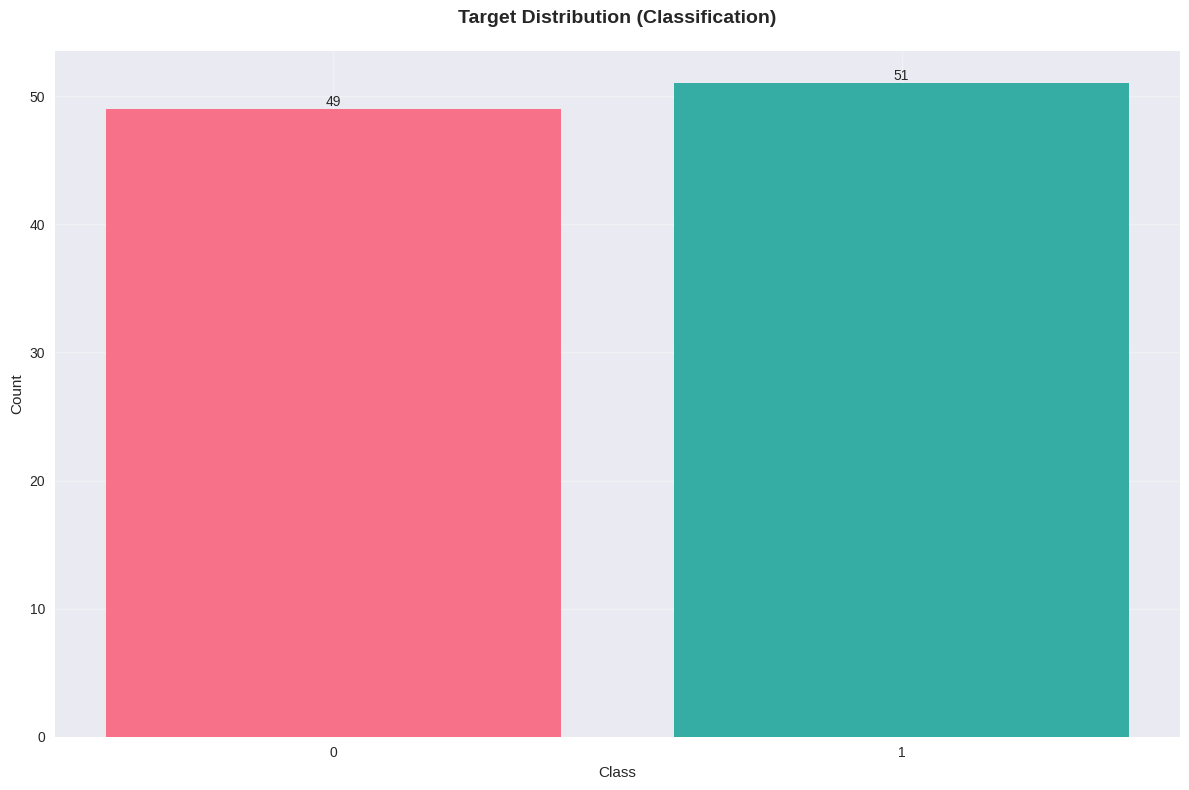

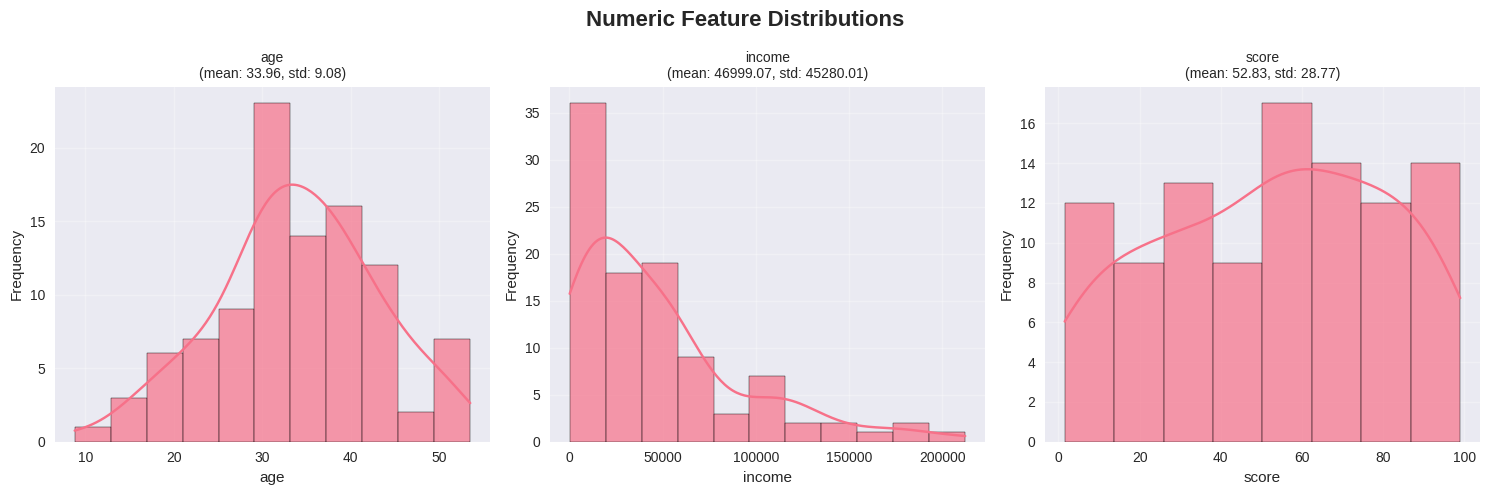

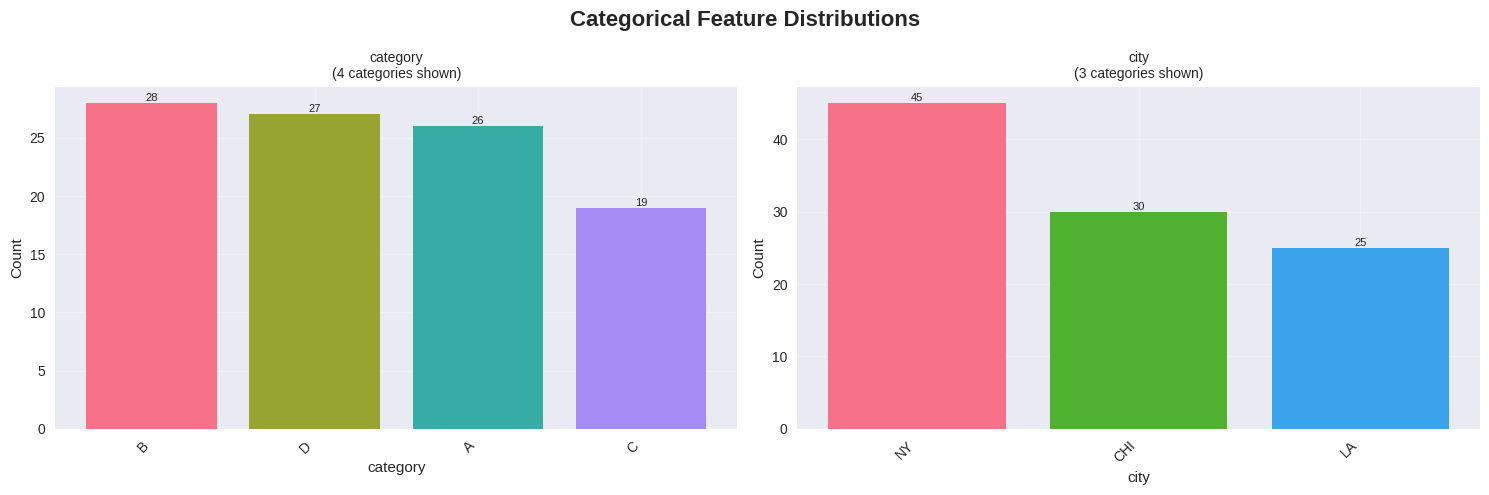

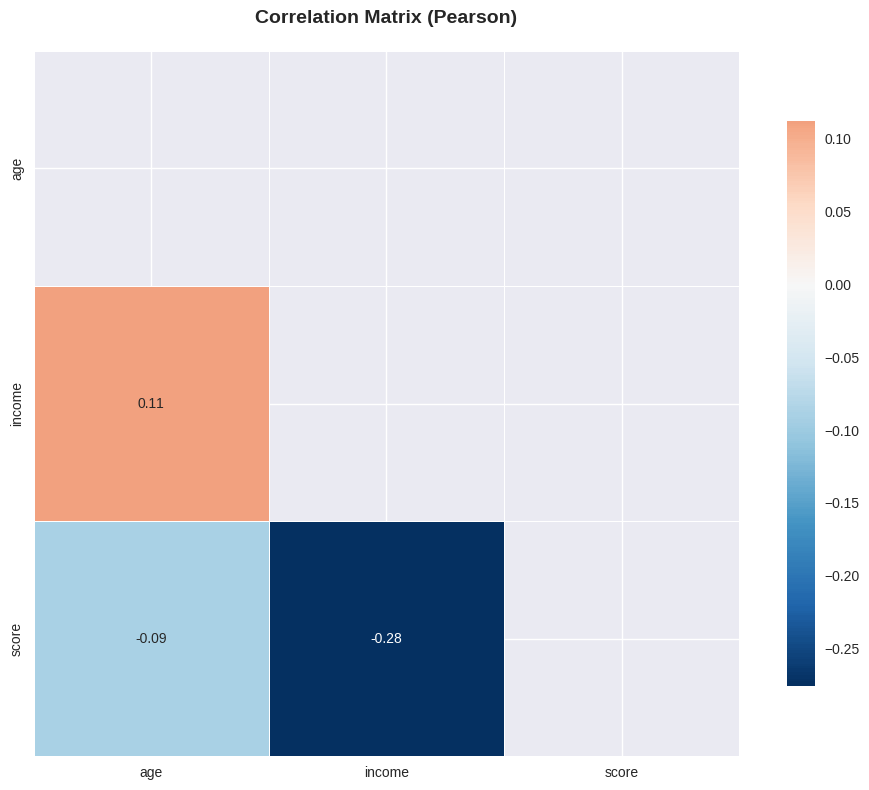

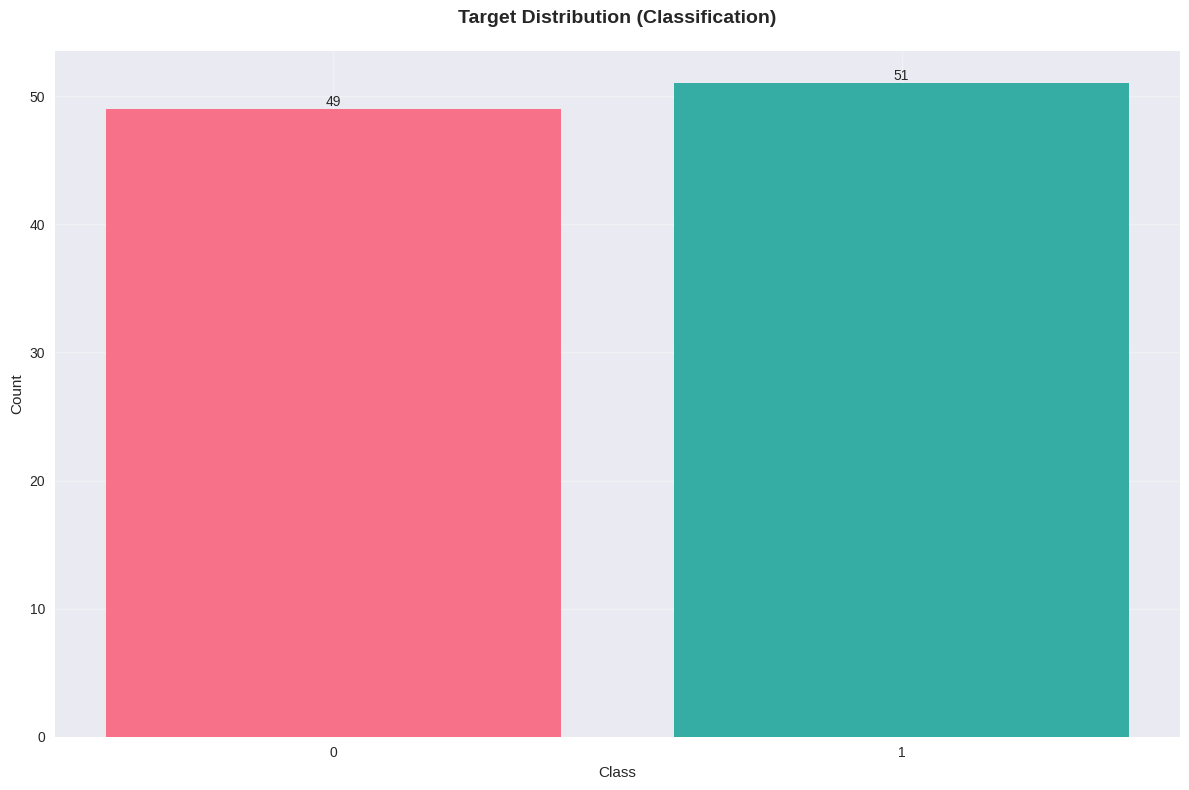

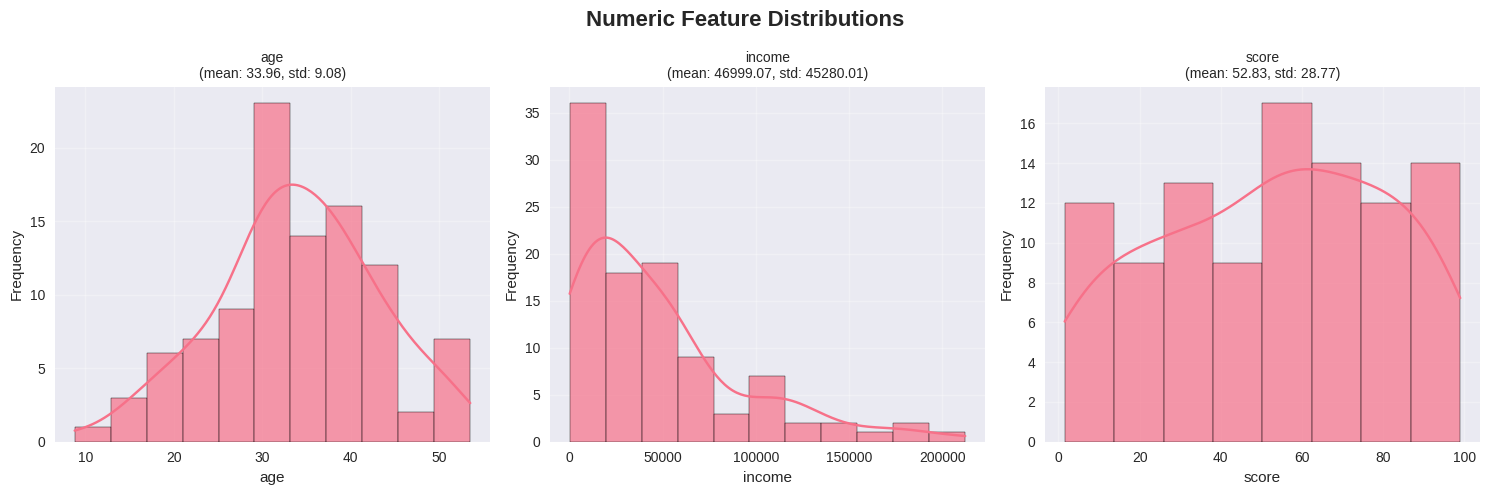

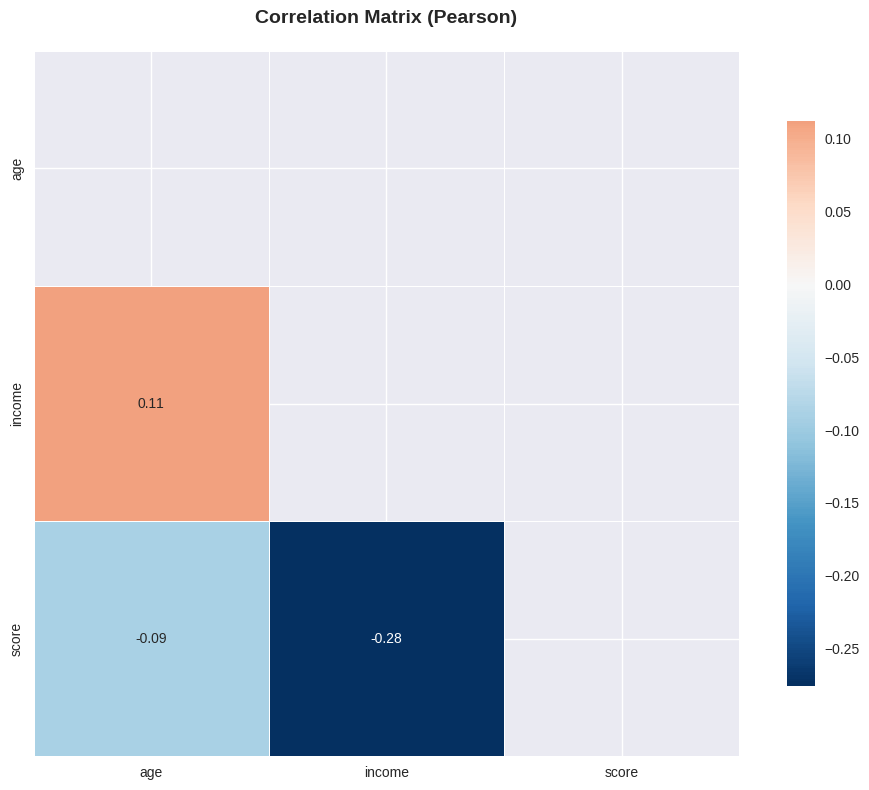

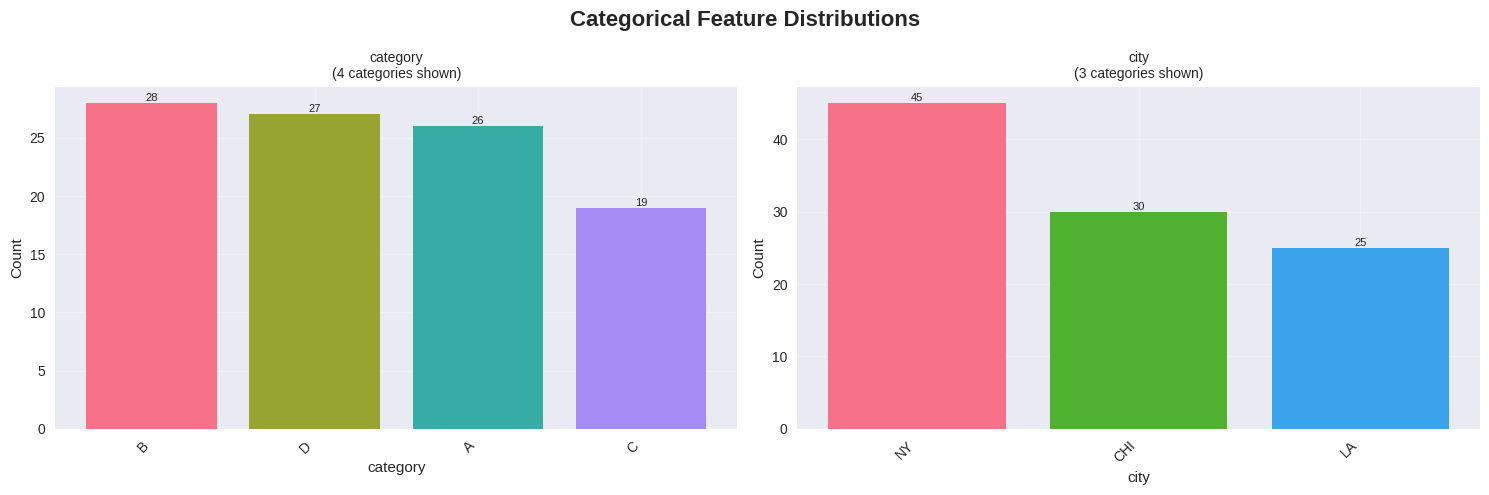

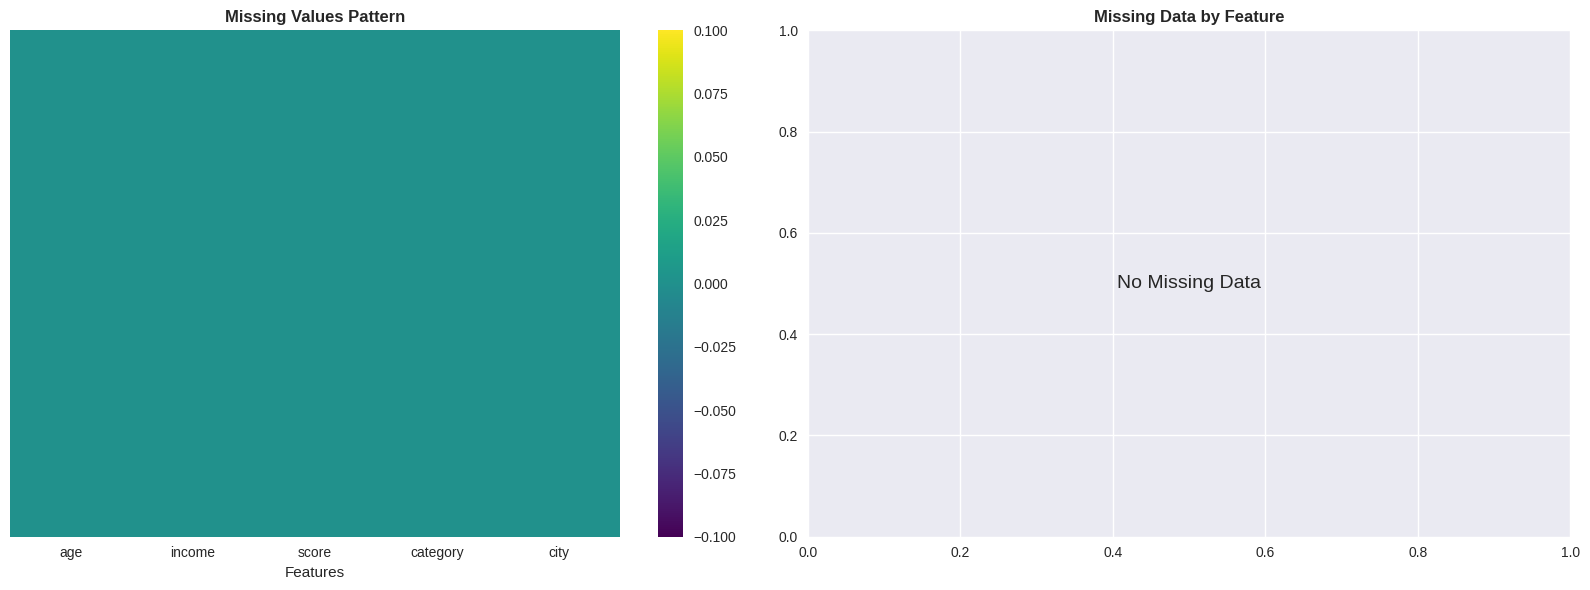

In [3]:
from typing import Optional, List, Union, Dict, Any
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from pathlib import Path
import logging

# Set up logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

class DataPlotter:
    """
    Immutable data visualization utility for exploratory data analysis.
    Preserves data purity - all operations are read-only.
    """

    def __init__(
        self,
        X: pd.DataFrame,
        y: Optional[pd.Series] = None,
        figsize: tuple = (12, 8),
        style: str = "seaborn-v0_8"
    ) -> None:
        """
        Initialize with data. Creates internal copies to ensure immutability.

        Args:
            X: Feature dataframe (will be copied internally)
            y: Optional target series (will be copied internally)
            figsize: Default figure size
            style: Matplotlib style to use
        """
        self._X = X.copy()
        self._y = y.copy() if y is not None else None
        self._figsize = figsize
        self._style = style

        # Configure plotting style once
        plt.style.use(self._style)
        sns.set_palette("husl")

    @property
    def data_shape(self) -> tuple:
        """Get shape of current data."""
        return self._X.shape

    @property
    def numeric_columns(self) -> List[str]:
        """Get list of numeric column names."""
        return self._X.select_dtypes(include=np.number).columns.tolist()

    @property
    def categorical_columns(self) -> List[str]:
        """Get list of categorical column names."""
        return self._X.select_dtypes(include=['object', 'category']).columns.tolist()

    def _save_plot(self, filename: Optional[str] = None, dpi: int = 300) -> None:
        """
        Save current plot if filename provided.

        Args:
            filename: Optional filename to save plot
            dpi: Image resolution for saved plot
        """
        if filename:
            Path(filename).parent.mkdir(parents=True, exist_ok=True)
            plt.savefig(filename, dpi=dpi, bbox_inches='tight', facecolor='white')
            logger.info(f"Plot saved to: {filename}")

    def _create_figure(self, title: str, figsize: Optional[tuple] = None) -> plt.Figure:
        """Create figure with consistent styling."""
        figsize = figsize or self._figsize
        fig, ax = plt.subplots(figsize=figsize)
        plt.title(title, fontsize=14, fontweight='bold', pad=20)
        return fig, ax

    def plot_target_distribution(
        self,
        problem_type: str = 'classification',
        figsize: Optional[tuple] = None,
        filename: Optional[str] = None
    ) -> 'DataPlotter':
        """
        Plot distribution of target variable.

        Args:
            problem_type: 'classification' or 'regression'
            figsize: Optional figure size
            filename: Optional filename to save plot

        Returns:
            self for method chaining
        """
        if self._y is None:
            logger.warning("No target variable provided for plotting")
            return self

        fig, ax = self._create_figure(f'Target Distribution ({problem_type.title()})', figsize)

        if problem_type == 'classification':
            value_counts = self._y.value_counts().sort_index()
            bars = ax.bar(range(len(value_counts)), value_counts.values,
                         color=sns.color_palette("husl", len(value_counts)))
            ax.set_xticks(range(len(value_counts)))
            ax.set_xticklabels(value_counts.index)
            ax.set_xlabel('Class')
            ax.set_ylabel('Count')

            # Add value labels on bars
            for bar in bars:
                height = bar.get_height()
                ax.text(bar.get_x() + bar.get_width()/2., height,
                       f'{int(height)}', ha='center', va='bottom')
        else:
            ax.hist(self._y, bins=30, edgecolor='black', alpha=0.7,
                   color=sns.color_palette("husl", 1)[0])
            ax.set_xlabel('Target Value')
            ax.set_ylabel('Frequency')

            # Add statistics
            mean_val = self._y.mean()
            std_val = self._y.std()
            ax.axvline(mean_val, color='red', linestyle='--', alpha=0.8,
                      label=f'Mean: {mean_val:.2f}')
            ax.axvline(mean_val + std_val, color='orange', linestyle='--', alpha=0.6)
            ax.axvline(mean_val - std_val, color='orange', linestyle='--', alpha=0.6)
            ax.legend()

        ax.grid(True, alpha=0.3)
        plt.tight_layout()
        self._save_plot(filename)
        plt.show()

        return self

    def plot_numeric_features(
        self,
        features: Optional[List[str]] = None,
        max_features: int = 9,
        figsize: Optional[tuple] = None,
        filename: Optional[str] = None
    ) -> 'DataPlotter':
        """
        Plot distributions of numeric features.

        Args:
            features: Specific numeric features to plot, None for all
            max_features: Maximum number of features to plot
            figsize: Optional figure size
            filename: Optional filename to save plot

        Returns:
            self for method chaining
        """
        if features is None:
            features = self.numeric_columns

        if not features:
            logger.warning("No numeric features found to plot")
            return self

        features = features[:max_features]
        n_cols = 3
        n_rows = (len(features) + n_cols - 1) // n_cols
        figsize = figsize or (15, 5 * n_rows)

        fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
        axes = np.array(axes).flatten()

        for i, feature in enumerate(features):
            if feature not in self._X.columns:
                logger.warning(f"Feature '{feature}' not found in data")
                continue

            ax = axes[i]
            data = self._X[feature].dropna()

            # Create histogram with KDE
            sns.histplot(data, ax=ax, kde=True, alpha=0.7, edgecolor='black')
            ax.set_xlabel(feature)
            ax.set_ylabel('Frequency')
            ax.set_title(f'{feature}\n(mean: {data.mean():.2f}, std: {data.std():.2f})', fontsize=10)
            ax.grid(True, alpha=0.3)

        # Hide empty subplots
        for j in range(i + 1, len(axes)):
            axes[j].set_visible(False)

        plt.suptitle('Numeric Feature Distributions', fontsize=16, fontweight='bold', y=0.98)
        plt.tight_layout()
        self._save_plot(filename)
        plt.show()

        return self

    def plot_categorical_features(
        self,
        features: Optional[List[str]] = None,
        max_features: int = 6,
        max_categories: int = 10,
        figsize: Optional[tuple] = None,
        filename: Optional[str] = None
    ) -> 'DataPlotter':
        """
        Plot distributions of categorical features.

        Args:
            features: Specific categorical features to plot, None for all
            max_features: Maximum number of features to plot
            max_categories: Maximum categories to show per feature
            figsize: Optional figure size
            filename: Optional filename to save plot

        Returns:
            self for method chaining
        """
        if features is None:
            features = self.categorical_columns

        if not features:
            logger.warning("No categorical features found to plot")
            return self

        features = features[:max_features]
        n_cols = 2
        n_rows = (len(features) + n_cols - 1) // n_cols
        figsize = figsize or (15, 5 * n_rows)

        fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
        axes = np.array(axes).flatten()

        for i, feature in enumerate(features):
            if feature not in self._X.columns:
                logger.warning(f"Feature '{feature}' not found in data")
                continue

            ax = axes[i]
            value_counts = self._X[feature].value_counts().head(max_categories)

            bars = ax.bar(range(len(value_counts)), value_counts.values,
                         color=sns.color_palette("husl", len(value_counts)))
            ax.set_xticks(range(len(value_counts)))
            ax.set_xticklabels(value_counts.index, rotation=45, ha='right')
            ax.set_xlabel(feature)
            ax.set_ylabel('Count')
            ax.set_title(f'{feature}\n({len(value_counts)} categories shown)', fontsize=10)
            ax.grid(True, alpha=0.3)

            # Add value labels on bars
            for bar in bars:
                height = bar.get_height()
                ax.text(bar.get_x() + bar.get_width()/2., height,
                       f'{int(height)}', ha='center', va='bottom', fontsize=8)

        # Hide empty subplots
        for j in range(i + 1, len(axes)):
            axes[j].set_visible(False)

        plt.suptitle('Categorical Feature Distributions', fontsize=16, fontweight='bold', y=0.98)
        plt.tight_layout()
        self._save_plot(filename)
        plt.show()

        return self

    def plot_correlation_heatmap(
        self,
        method: str = 'pearson',
        figsize: Optional[tuple] = None,
        filename: Optional[str] = None
    ) -> 'DataPlotter':
        """
        Plot correlation heatmap for numeric features.

        Args:
            method: Correlation method ('pearson', 'spearman', 'kendall')
            figsize: Optional figure size
            filename: Optional filename to save plot

        Returns:
            self for method chaining
        """
        numeric_cols = self.numeric_columns
        if len(numeric_cols) < 2:
            logger.warning("Need at least 2 numeric features for correlation heatmap")
            return self

        fig, ax = self._create_figure(f'Correlation Matrix ({method.title()})', figsize or (10, 8))

        corr_matrix = self._X[numeric_cols].corr(method=method)
        mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

        # Create heatmap
        sns.heatmap(
            corr_matrix,
            mask=mask,
            annot=True,
            fmt='.2f',
            cmap='RdBu_r',
            center=0,
            square=True,
            linewidths=0.5,
            cbar_kws={'shrink': 0.8},
            ax=ax
        )

        plt.tight_layout()
        self._save_plot(filename)
        plt.show()

        return self

    def plot_missing_data(
        self,
        figsize: Optional[tuple] = None,
        filename: Optional[str] = None
    ) -> 'DataPlotter':
        """
        Plot missing data pattern.

        Args:
            figsize: Optional figure size
            filename: Optional filename to save plot

        Returns:
            self for method chaining
        """
        missing_data = self._X.isnull()
        missing_percentage = (missing_data.sum() / len(self._X)) * 100

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize or (16, 6))

        # Heatmap of missing values
        sns.heatmap(missing_data, cbar=True, yticklabels=False,
                   cmap='viridis', ax=ax1)
        ax1.set_title('Missing Values Pattern', fontweight='bold')
        ax1.set_xlabel('Features')

        # Bar plot of missing percentages
        missing_percentage_sorted = missing_percentage.sort_values(ascending=False)
        missing_percentage_sorted = missing_percentage_sorted[missing_percentage_sorted > 0]

        if len(missing_percentage_sorted) > 0:
            bars = ax2.bar(range(len(missing_percentage_sorted)),
                          missing_percentage_sorted.values,
                          color=sns.color_palette("Reds", len(missing_percentage_sorted)))
            ax2.set_xticks(range(len(missing_percentage_sorted)))
            ax2.set_xticklabels(missing_percentage_sorted.index, rotation=45, ha='right')
            ax2.set_ylabel('Missing Percentage (%)')
            ax2.set_title('Missing Data by Feature', fontweight='bold')
            ax2.grid(True, alpha=0.3)

            # Add percentage labels on bars
            for bar in bars:
                height = bar.get_height()
                ax2.text(bar.get_x() + bar.get_width()/2., height,
                        f'{height:.1f}%', ha='center', va='bottom')
        else:
            ax2.text(0.5, 0.5, 'No Missing Data', ha='center', va='center',
                    transform=ax2.transAxes, fontsize=14)
            ax2.set_title('Missing Data by Feature', fontweight='bold')

        plt.tight_layout()
        self._save_plot(filename)
        plt.show()

        return self

    def plot_feature_relationships(
        self,
        x_feature: str,
        y_feature: str,
        hue_feature: Optional[str] = None,
        figsize: Optional[tuple] = None,
        filename: Optional[str] = None
    ) -> 'DataPlotter':
        """
        Plot relationship between two features.

        Args:
            x_feature: Feature for x-axis
            y_feature: Feature for y-axis
            hue_feature: Optional feature for color coding
            figsize: Optional figure size
            filename: Optional filename to save plot

        Returns:
            self for method chaining
        """
        if x_feature not in self._X.columns or y_feature not in self._X.columns:
            logger.warning("Specified features not found in data")
            return self

        fig, ax = self._create_figure(f'{x_feature} vs {y_feature}', figsize)

        if hue_feature and hue_feature in self._X.columns:
            scatter = ax.scatter(self._X[x_feature], self._X[y_feature],
                               c=pd.factorize(self._X[hue_feature])[0],
                               alpha=0.6, cmap='viridis')
            plt.colorbar(scatter, ax=ax, label=hue_feature)
        else:
            ax.scatter(self._X[x_feature], self._X[y_feature], alpha=0.6)

        ax.set_xlabel(x_feature)
        ax.set_ylabel(y_feature)
        ax.grid(True, alpha=0.3)

        plt.tight_layout()
        self._save_plot(filename)
        plt.show()

        return self

    def comprehensive_eda(
        self,
        problem_type: str = 'classification',
        save_prefix: Optional[str] = None
    ) -> 'DataPlotter':
        """
        Run comprehensive exploratory data analysis with all plots.

        Args:
            problem_type: 'classification' or 'regression'
            save_prefix: Optional prefix for saved plot files

        Returns:
            self for method chaining
        """
        def _get_filename(plot_name: str) -> Optional[str]:
            return f"{save_prefix}_{plot_name}.png" if save_prefix else None

        logger.info("Starting comprehensive EDA...")

        # Target distribution
        if self._y is not None:
            self.plot_target_distribution(problem_type, filename=_get_filename('target_dist'))

        # Numeric features
        if self.numeric_columns:
            self.plot_numeric_features(filename=_get_filename('numeric_features'))
            self.plot_correlation_heatmap(filename=_get_filename('correlation_matrix'))

        # Categorical features
        if self.categorical_columns:
            self.plot_categorical_features(filename=_get_filename('categorical_features'))

        # Missing data
        self.plot_missing_data(filename=_get_filename('missing_data'))

        logger.info("Comprehensive EDA completed")
        return self


# Example usage
if __name__ == "__main__":
    # Create sample data
    np.random.seed(42)
    X = pd.DataFrame({
        'age': np.random.normal(35, 10, 100),
        'income': np.random.exponential(50000, 100),
        'score': np.random.uniform(0, 100, 100),
        'category': np.random.choice(['A', 'B', 'C', 'D'], 100),
        'city': np.random.choice(['NY', 'LA', 'CHI'], 100)
    })
    y = pd.Series(np.random.choice([0, 1], 100), name='target')

    # Initialize plotter (data is copied internally)
    plotter = DataPlotter(X, y)

    # Individual plots
    (plotter.plot_target_distribution('classification', filename='target.png')
     .plot_numeric_features(filename='numeric.png')
     .plot_categorical_features(filename='categorical.png')
     .plot_correlation_heatmap(filename='correlation.png'))

    # Or comprehensive EDA
    plotter.comprehensive_eda(save_prefix='my_analysis')

## (My Step 1) Load Data

In [5]:
# dgender = pd.read_csv(folderPath + 'Titanic_gender_submission.csv') # example of submission format
dTrain = pd.read_csv(folderPath+'Titanic_train.csv')
dTest = pd.read_csv(folderPath+'Titanic_test.csv')

In [7]:
dgender.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
